In [2]:
import os
import sys
import logging
import gc

import numpy as np
from scipy import interpolate
from astropy.cosmology import Planck18
import astropy.units as u

from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp

import py21cmfast as p21c
from py21cmfast import cache_tools

sys.path.append(os.environ['DH_DIR'])
from darkhistory.spec.spectrum import Spectrum

sys.path.append(os.environ['DM21CM_DIR'])
import dm21cm.physics as phys
from dm21cm.dh_wrappers import DarkHistoryWrapper, TransferFunctionWrapper
from dm21cm.utils import load_h5_dict
from dm21cm.data_cacher import Cacher
from dm21cm.profiler import Profiler

logging.getLogger().setLevel(logging.INFO)
logging.getLogger('21cmFAST').setLevel(logging.CRITICAL+1)
logging.getLogger('py21cmfast._utils').setLevel(logging.CRITICAL+1)
logging.getLogger('py21cmfast.wrapper').setLevel(logging.CRITICAL+1)

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [3]:
from dm21cm.evolve import get_z_edges, split_xray, gen_injection_boxes, p21c_step

In [4]:
from dm21cm.dm_params import DMParams

run_name = 'step_test_bath'

os.environ['DM21CM_DATA_DIR'] = '/n/holyscratch01/iaifi_lab/yitians/dm21cm/DM21cm/data/tf/zf01/data'

# set global params
p21c.global_params.CLUMPING_FACTOR = 1.
p21c.global_params.Pop2_ion = 0.


run_name = run_name
z_start = 45.
z_end = 5.
dm_params = DMParams(
    mode='decay',
    primary='phot_delta',
    m_DM=3e3, # [eV]
    lifetime=1e26, # [s]
)
enable_elec = False

p21c_initial_conditions = p21c.initial_conditions(
    user_params = p21c.UserParams(
        HII_DIM = 32,
        BOX_LEN = 32 * 2, # [conformal Mpc]
        N_THREADS = 32,
    ),
    cosmo_params = p21c.CosmoParams(
        OMm = Planck18.Om0,
        OMb = Planck18.Ob0,
        POWER_INDEX = Planck18.meta['n'],
        SIGMA_8 = Planck18.meta['sigma8'],
        hlittle = Planck18.h,
    ),
    random_seed = 54321,
    write = True,
)
p21c_astro_params = p21c.AstroParams(L_X = 0.) # log10 value

clear_cache = True
tf_on_device = True

debug_all_bath = True

# defaults
use_DH_init=True
rerun_DH=False
use_tqdm=True
no_injection=False

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/inputs.py:487: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


In [5]:
logging.info(f'Using 21cmFAST version {p21c.__version__}')

#===== data and cache =====
data_dir = os.environ['DM21CM_DATA_DIR']
cache_dir = os.environ['P21C_CACHE_DIR'] + '/' + run_name
p21c.config['direc'] = cache_dir
logging.info(f"Cache dir: {cache_dir}")
os.makedirs(cache_dir, exist_ok=True)
if clear_cache:
    cache_tools.clear_cache()
gc.collect()

#===== initialize =====
#--- physics parameters ---
abscs = load_h5_dict(f"{data_dir}/abscissas.h5")
dm_params.set_inj_specs(abscs)

EPSILON = 1e-6
p21c.global_params.Z_HEAT_MAX = z_start + EPSILON
p21c.global_params.ZPRIME_STEP_FACTOR = abscs['zplusone_step_factor']

box_dim = p21c_initial_conditions.user_params.HII_DIM
box_len = p21c_initial_conditions.user_params.BOX_LEN
cosmo = Planck18

#--- DarkHistory and transfer functions ---
tf_wrapper = TransferFunctionWrapper(
    box_dim = box_dim,
    abscs = abscs,
    prefix = data_dir,
    enable_elec = enable_elec,
    on_device = tf_on_device,
)

#--- xray ---
xray_cacher = Cacher(data_path=f"{cache_dir}/xray_brightness.h5", cosmo=cosmo, N=box_dim, dx=box_len/box_dim)
xray_cacher.clear_cache()

#--- redshift stepping ---
z_edges = get_z_edges(z_start, z_end, p21c.global_params.ZPRIME_STEP_FACTOR)

#===== initial steps =====
dh_wrapper = DarkHistoryWrapper(dm_params, prefix=p21c.config[f'direc'])

# We have to synchronize at the second step because 21cmFAST acts weird in the first step:
# - global_params.TK_at_Z_HEAT_MAX is not set correctly (it is probably set and evolved for a step)
# - global_params.XION_at_Z_HEAT_MAX is not set correctly (it is probably set and evolved for a step)
# - first step ignores any values added to spin_temp.Tk_box and spin_temp.x_e_box
z_match = z_edges[1]
if use_DH_init:
    dh_wrapper.evolve(end_rs=(1+z_match)*0.9, rerun=rerun_DH)
    T_k_DH_init, x_e_DH_init, phot_bath_spec = dh_wrapper.get_init_cond(rs=1+z_match)
else:
    phot_bath_spec = Spectrum(abscs['photE'], np.zeros_like(abscs['photE']), spec_type='N', rs=1+z_match) # [ph / Bavg]

perturbed_field = p21c.perturb_field(redshift=z_edges[1], init_boxes=p21c_initial_conditions, write = True)
spin_temp, ionized_box, brightness_temp = p21c_step(perturbed_field=perturbed_field, spin_temp=None, ionized_box=None, astro_params=p21c_astro_params)
if use_DH_init:
    spin_temp.Tk_box += T_k_DH_init - np.mean(spin_temp.Tk_box)
    spin_temp.x_e_box += x_e_DH_init - np.mean(spin_temp.x_e_box)
    ionized_box.xH_box = 1 - spin_temp.x_e_box

#===== main loop =====
z_edges = z_edges[1:] # Maybe fix this later
z_range = range(len(z_edges)-1)
records = []
profiler = Profiler()

#--- trackers ---
i_xray_loop_start = 0 # where we start looking for annuli

INFO:root:Using 21cmFAST version 0.1.dev1595+gf14ec0d.d20231113
INFO:root:Cache dir: /n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/step_test_bath


INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:root:TransferFunctionWrapper: Loaded photon transfer functions.
INFO:root:TransferFunctionWrapper: Skipping electron transfer functions.
INFO:root:DarkHistoryWrapper: Running DarkHistory to generate initial conditions...


****** Loading transfer functions... ******
Using data at /n/holyscratch01/iaifi_lab/yitians/darkhistory/DHdata_v1_1
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******
Loading time: 8.244 s


  0%|          | 2/430 [00:00<00:37, 11.34it/s]

Initialization time: 0.042 s


100%|██████████| 430/430 [00:46<00:00,  9.32it/s]
INFO:root:DarkHistoryWrapper: Saved DarkHistory initial conditions.


Main loop time: 46.101 s


## LOOP

In [6]:
i_z = 0

In [12]:
i_z += 1
print(i_z)

1


In [29]:
print_str = f'i_z={i_z}/{len(z_edges)-2} z={z_edges[i_z]:.2f}'

#===== physical quantities =====
z_current = z_edges[i_z]
z_next = z_edges[i_z+1]
dt = phys.dt_step(z_current, np.exp(abscs['dlnz']))

#--- for interpolation ---
delta_plus_one_box = 1 + np.asarray(perturbed_field.density)
x_e_box = np.asarray(1 - ionized_box.xH_box)
T_k_box = np.asarray(spin_temp.Tk_box)
tf_wrapper.init_step(rs=1+z_current, delta_plus_one_box=delta_plus_one_box, x_e_box=x_e_box, T_k_box=T_k_box)

#--- for dark matter ---
nBavg = phys.n_B * (1+z_current)**3 # [Bavg / (physical cm)^3]
rho_DM_box = delta_plus_one_box * phys.rho_DM * (1+z_current)**3 # [eV/(physical cm)^3]
inj_per_Bavg_box = phys.inj_rate(rho_DM_box, dm_params) * dt * dm_params.struct_boost(1+z_current) / nBavg # [inj/Bavg]


In [ ]:
if i_z == 0:
    tmp_phot_bath_spec = phot_bath_spec * 0.

In [31]:
debug_all_bath = True

#===== photon injection and energy deposition =====
#--- xray ---
profiler.start()

print(i_xray_loop_start, i_z)
for i_z_shell in range(i_xray_loop_start, i_z):
    xray_brightness_box, xray_spec, is_box_average = xray_cacher.get_annulus_data(
        z_current, z_edges[i_z_shell], z_edges[i_z_shell+1]
    )
    if debug_all_bath:
        xray_brightness_box = jnp.mean(xray_brightness_box) * jnp.ones_like(xray_brightness_box)
        tmp_phot_bath_spec.N += xray_spec.N                         # then we can just dump to the global bath spectrum
        i_xray_loop_start = max(i_z_shell+1, i_xray_loop_start)
    else:
        if is_box_average:                                          # if smoothing scale > box size,
            phot_bath_spec.N += xray_spec.N                         # then we can just dump to the global bath spectrum
            i_xray_loop_start = max(i_z_shell+1, i_xray_loop_start) # and we will not revisit this shell
        else:
            tf_wrapper.inject_phot(xray_spec, inject_type='xray', weight_box=xray_brightness_box)

print(i_xray_loop_start)
profiler.record('xray')

0 1
1


In [32]:
np.mean(tf_wrapper.dep_box[...,0])

0.0

In [33]:
depion_before = np.mean(tf_wrapper.dep_box[..., 0])
tf_wrapper.inject_phot(tmp_phot_bath_spec, inject_type='bath')
depion = np.mean(tf_wrapper.dep_box[..., 0]) - depion_before
print(depion)

6.496666191368745e-05


In [35]:
tmp_phot_bath_spec.toteng()

0.001087229772020653

In [34]:
np.mean(tf_wrapper.dep_box, axis=(0, 1, 2))

Array([6.49666619e-05, 3.55585812e-06, 5.19096599e-05, 4.38975791e-05,
       2.27204876e-05, 3.64620423e-07], dtype=float64)

In [17]:
#--- bath and homogeneous portion of xray ---
depion_before = np.mean(tf_wrapper.dep_box[..., 0])
tf_wrapper.inject_phot(phot_bath_spec, inject_type='bath')

#--- dark matter (on-the-spot) ---
tf_wrapper.inject_from_dm(dm_params, inj_per_Bavg_box)
depion = np.mean(tf_wrapper.dep_box[..., 0]) - depion_before
print(depion)
profiler.record('bath+dm')

0.00041470431638919463


In [20]:
np.mean(tf_wrapper.dep_box[...,0])

Array(0.00047967, dtype=float64)

In [21]:
import matplotlib.pyplot as plt

[]

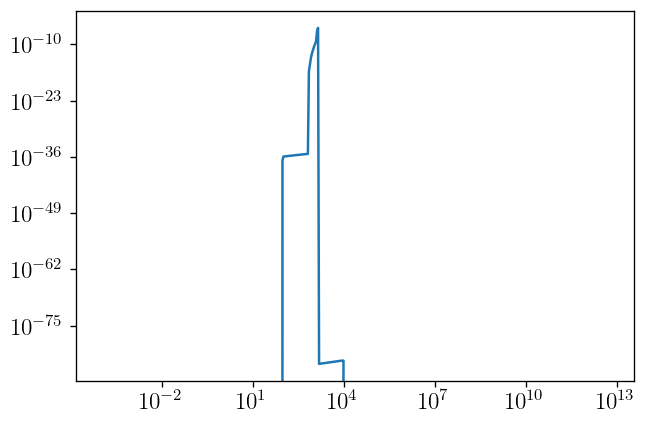

In [22]:
plt.plot(tmp_phot_bath_spec.eng, tmp_phot_bath_spec.N)
plt.loglog()

In [11]:
#===== 21cmFAST step =====
perturbed_field = p21c.perturb_field(redshift=z_next, init_boxes=p21c_initial_conditions)
input_heating, input_ionization, input_jalpha = gen_injection_boxes(z_next, p21c_initial_conditions)
tf_wrapper.populate_injection_boxes(input_heating, input_ionization, input_jalpha, dt,)
spin_temp, ionized_box, brightness_temp = p21c_step(
    perturbed_field, spin_temp, ionized_box,
    input_heating = input_heating,
    input_ionization = input_ionization,
    input_jalpha = input_jalpha,
    astro_params = p21c_astro_params
)

profiler.record('21cmFAST')

#===== prepare spectra for next step =====
#--- bath (separating out xray) ---
prop_phot_N = np.array(tf_wrapper.prop_phot_N) # propagating and emitted photons have been stored in tf_wrapper up to this point, time to get them out
emit_phot_N = np.array(tf_wrapper.emit_phot_N)
emit_bath_N, emit_xray_N = split_xray(emit_phot_N, abscs['photE'])
phot_bath_spec = Spectrum(abscs['photE'], prop_phot_N + emit_bath_N, rs=1+z_current, spec_type='N') # photons not emitted to the xray band are added to the bath (treated as uniform)
phot_bath_spec.redshift(1+z_next)

#--- xray ---
x_e_for_attenuation = 1 - np.mean(ionized_box.xH_box)
attenuation_arr = np.array(tf_wrapper.attenuation_arr(rs=1+z_current, x=np.mean(x_e_for_attenuation))) # convert from jax array
xray_cacher.advance_spectrum(attenuation_arr, z_next)

xray_spec = Spectrum(abscs['photE'], emit_xray_N, rs=1+z_current, spec_type='N') # [ph/Bavg]
xray_spec.redshift(1+z_next)
xray_tot_eng = np.dot(abscs['photE'], emit_xray_N)
if xray_tot_eng == 0.:
    xray_rel_eng_box = np.zeros_like(tf_wrapper.xray_eng_box)
else:
    xray_rel_eng_box = tf_wrapper.xray_eng_box / xray_tot_eng # [1 (relative energy)/Bavg]
if not no_injection:
    xray_cacher.cache(z_current, xray_rel_eng_box, xray_spec)

#===== calculate and save some quantities =====
dE_inj_per_Bavg = dm_params.eng_per_inj * np.mean(inj_per_Bavg_box) # [eV/Bavg]
dE_inj_per_Bavg_unclustered = dE_inj_per_Bavg / dm_params.struct_boost(1+z_current) # [eV/Bavg]

records.append({
    'z'   : z_next,
    'T_s' : np.mean(spin_temp.Ts_box), # [mK]
    'T_b' : np.mean(brightness_temp.brightness_temp), # [K]
    'T_k' : np.mean(spin_temp.Tk_box), # [K]
    'x_e' : np.mean(spin_temp.x_e_box), # [1]
    '1-x_H' : np.mean(1 - ionized_box.xH_box), # [1]
    'E_phot' : phot_bath_spec.toteng(), # [eV/Bavg]
    'phot_N' : phot_bath_spec.N, # [ph/Bavg]
    'dE_inj_per_B' : dE_inj_per_Bavg, # [eV/Bavg]
    'dE_inj_per_Bavg_unclustered' : dE_inj_per_Bavg_unclustered, # [eV/Bavg]
    'dep_ion'  : np.mean(tf_wrapper.dep_box[...,0] + tf_wrapper.dep_box[...,1]), # [eV/Bavg]
    'dep_exc'  : np.mean(tf_wrapper.dep_box[...,2]), # [eV/Bavg]
    'dep_heat' : np.mean(tf_wrapper.dep_box[...,3]), # [eV/Bavg]
    'x_e_slice' : np.array(spin_temp.x_e_box[0]), # [1]
    'x_H_slice' : np.array(ionized_box.xH_box[0]), # [1]
    'T_k_slice' : np.array(spin_temp.Tk_box[0]), # [K]
})